## Imports

In [3]:
# for loading the data
import cookielib
import urllib
import urllib2
import getpass
import sys
import json
# standard imports
from collections import defaultdict, OrderedDict
from copy import deepcopy
import math
# third party packages
import numpy as np
from scipy.cluster.vq import kmeans, kmeans2, vq, whiten
import matplotlib.pyplot as plt
%matplotlib notebook
#figsize(15, 9)
#matplotlib.rc("savefig", dpi=600)
# make plots zoom-able
import mpld3
mpld3.enable_notebook()

## Load Data

In [5]:
HOST = "https://working-dog-data-dash.appspot.com"

def create_opener():
    """creates a urllib2.OpenerDirector with a CookieJar"""
    cj = cookielib.CookieJar()
    opener = urllib2.build_opener(urllib2.HTTPCookieProcessor(cj))
    return opener

def login(opener):
    """prompts the cli user for login credentials to P.A.W.S.
     then sends a login request to the real server using opener.

    Arguments:
        opener - a urllib2.OpenerDirector, this should have a cookier jar.
    """
    login_url = HOST + "/login"
    print("Please enter credentials for P.A.W.S.")
    user = getpass.getpass("Userame: ")
    password = getpass.getpass("Password: ")
    form_data = {"username": user, "password": password}
    params = urllib.urlencode(form_data)
    response = opener.open(login_url, data=params)
    code = response.getcode()
    if code != 200:
        raise Exception("Failed to login!")

# login to backend service
opener = create_opener()
login(opener)

# fetch data from server
url = HOST + "/api/cached/data/blob"
response = opener.open(url)

# read and check result
raw = response.read()
if raw[0] != '{':
    raise Exception("Failed to load!")

# parse the JSON
# NOTE: we have no floats
# The data format is at:
# https://github.com/ChelsiAlise/workingdogdatadash/blob/master/data.go
blob = json.loads(raw, parse_int=int, parse_float=int)

# Debug loaded data
num_dogs = len(blob["dogs"])
print ""
print "Loaded data with num_dogs = %d" % (num_dogs)

Please enter credentials for P.A.W.S.
Userame: ········
Password: ········

Loaded data with num_dogs = 124


## Clean Data

In [6]:
# define small common utilities
def print_bar():
    print "-"*70

# define constants
DAY_MINS = 1440

In [7]:
# make dict of data by dog id
dogs = {}
for dog in blob["dogs"]:
    id = dog["id"]
    dog["dog_status"] = dog["dog_status"].encode('utf8')
    dogs[id] = dog
    dogs[id]["days"] = []

# copy day info to dogs
# filter days for minimum percentage
MIN_DAY_PERCENT = 75
MIN_DAY_MINUTES = int(DAY_MINS * float(MIN_DAY_PERCENT)/100)
print "Filtering to contain at least %d mins (~%d%%)." %\
    (MIN_DAY_MINUTES, MIN_DAY_PERCENT)
print ""
days_removed = {id:0 for id in dogs}
for day in blob["days"]:
    date = day["date"]
    for day_data in day["dogs"]:
        id = day_data["id"]
        # check if day is below threshold and add or remove
        if day_data["total"] < MIN_DAY_MINUTES:
            # remove the day from the totals
            dog["awake"] -= day_data["awake"]
            dog["active"] -= day_data["active"]
            dog["rest"] -= day_data["rest"]
            dog["total"] -= day_data["total"]
            # note how many days were removed for this dog
            days_removed[id] += 1
        else:
            # copy day over
            dogs[id]["days"].append(day_data)
            dogs[id]["days"][-1]["date"] = date
print "Average days removed: %d" % \
    (np.mean([v for v in days_removed.values()]))            
print "Number of days after filtering least to most:"
print_bar()
print sorted([len(dogs[id]["days"]) for id in dogs])

Filtering to contain at least 1080 mins (~75%).

Average days removed: 42
Number of days after filtering least to most:
----------------------------------------------------------------------
[26, 37, 37, 43, 44, 48, 48, 57, 59, 65, 68, 68, 81, 81, 84, 84, 87, 89, 97, 126, 138, 141, 144, 159, 171, 190, 218, 227, 229, 229, 249, 254, 259, 261, 274, 297, 299, 299, 315, 319, 334, 335, 338, 343, 353, 355, 356, 360, 361, 364, 365, 369, 376, 377, 392, 393, 398, 408, 409, 421, 436, 440, 441, 450, 459, 460, 460, 466, 474, 477, 480, 481, 482, 483, 490, 491, 493, 495, 497, 499, 499, 499, 502, 504, 506, 509, 513, 514, 518, 521, 525, 531, 535, 536, 538, 542, 547, 550, 554, 560, 563, 583, 585, 588, 602, 603, 603, 606, 615, 615, 625, 628, 629, 631, 631, 633, 644, 645, 645, 662, 668, 672, 674, 674]


In [8]:
# get and sort all totals for analysis
totals = sorted([dog["total"] for dog in blob["dogs"]])
print "Minute Totals:"
print_bar()
total_mean = np.mean(totals)
total_std = np.std(totals)
total_ten_pct = totals[int(len(totals)*.1)]
# print helper
def print_value_days_weeks(name, value):
    print "%10s: %10f (mins), %10f (days), %10f (weeks)" %\
        (name, value, value/DAY_MINS, value/DAY_MINS/7)
print_value_days_weeks("Mean", total_mean)
print_value_days_weeks("Std-Dev", total_std)
print_value_days_weeks("Bottom 10%", total_ten_pct)
print_value_days_weeks("Mean - Std", total_mean - total_std)
print_bar()

Minute Totals:
----------------------------------------------------------------------
      Mean: 553413.701613 (mins), 384.315071 (days),  54.902153 (weeks)
   Std-Dev: 465861.619433 (mins), 323.515013 (days),  46.216430 (weeks)
Bottom 10%: 122765.000000 (mins),  85.000000 (days),  12.000000 (weeks)
Mean - Std: 87552.082180 (mins),  60.800057 (days),   8.685722 (weeks)
----------------------------------------------------------------------


In [9]:
# filter to have at least 1/2 year of valid days
total_threshold = 26 * 7

filtered_dogs = {}
removed_dogs_by_outcome = defaultdict(list)
for k, v in dogs.iteritems():
    if len(v["days"]) >= total_threshold:
        filtered_dogs[k] = deepcopy(v)
    else:
        status = v["dog_status"]
        if not status: status = "Unkown Status"
        removed_dogs_by_outcome[status].append(v)

num_below_threshold = len(dogs) - len(filtered_dogs)

print "Number of dogs below threshold: %d" % (num_below_threshold)
print "      Number of remaining dogs: %d" % (len(filtered_dogs))

print_bar()

for k, v in removed_dogs_by_outcome.iteritems():
    print "Outcome: %18s   => %3d dogs removed." % ("'"+k+"'", len(v))

Number of dogs below threshold: 25
      Number of remaining dogs: 99
----------------------------------------------------------------------
Outcome:   'Active Breeder'   =>   4 dogs removed.
Outcome:    'Unkown Status'   =>   7 dogs removed.
Outcome:  'Active Grad Dog'   =>   8 dogs removed.
Outcome:     'Released Dog'   =>   6 dogs removed.


## Analyze Data

In [10]:
# first put the dog data into buckets by outcome
dogs_by_outcome = defaultdict(list)
for dog in filtered_dogs.itervalues():
    status = dog["dog_status"]
    if status == "":
        status = "Unknown Status"
    dogs_by_outcome[status].append(dog)

# create alphabetically sorted set of possible outcomes
outcomes = sorted(dogs_by_outcome.keys())

print "Outcomes:"
print_bar()

# analyze dogs by outcome
results_by_outcome = {}
for outcome in outcomes:
    results = OrderedDict()
    results["outcome"] = outcome,
    results["dogs"] = []
    # convert to percentages instead of totals
    for dog in dogs_by_outcome[outcome]:
        total = dog["total"]
        dog["active%"] = float(dog["active"]) / total * 100
        dog["rest%"] = float(dog["rest"]) / total * 100
        dog["awake%"] = float(dog["awake"]) / total * 100
        results["dogs"].append(dog)
    # compute means over outcome
    active = [v["active%"] for v in results["dogs"]]
    awake = [v["awake%"] for v in results["dogs"]]
    rest = [v["rest%"] for v in results["dogs"]]
    results["num_dogs"] = len(active)
    results["active_mean"] = np.mean(active)
    results["active_std"] = np.std(active)
    results["awake_mean"] = np.mean(awake)
    results["awake_std"] = np.std(awake)
    results["rest_mean"] = np.mean(rest)
    results["rest_std"] = np.std(rest)
    # print results for outcome
    print "     Outcome:  " + outcome
    for key in results.keys():
        if key not in ["dogs", "outcome"]:
            print "%12s: %10f" % (key, results[key])
    print_bar()
    results_by_outcome[outcome] = results

Outcomes:
----------------------------------------------------------------------
     Outcome:  Active Breeder
    num_dogs:   6.000000
 active_mean:   6.506023
  active_std:   0.941661
  awake_mean:  31.926973
   awake_std:   1.894497
   rest_mean:  61.567003
    rest_std:   1.614238
----------------------------------------------------------------------
     Outcome:  Active Grad Dog
    num_dogs:  44.000000
 active_mean:   6.767613
  active_std:   2.060211
  awake_mean:  31.866944
   awake_std:   2.725910
   rest_mean:  61.365442
    rest_std:   3.601427
----------------------------------------------------------------------
     Outcome:  Advanced Training
    num_dogs:   5.000000
 active_mean:   6.840871
  active_std:   0.740723
  awake_mean:  31.235784
   awake_std:   2.427425
   rest_mean:  61.923345
    rest_std:   2.846792
----------------------------------------------------------------------
     Outcome:  Released Dog
    num_dogs:  38.000000
 active_mean:   6.615200
  active_

In [18]:
# same as above but only with succes/failed statuses
print "Active / Released (Active Grad Dog or Active Breeder / Released Dog):"
print_bar()
results_by_success = {}
for outcome, results in results_by_outcome.iteritems():
    # skip dogs we don't have a final result for
    if outcome in ["Unknown Status", "Advanced Training"]:
        continue
    # combine successes
    elif outcome in ["Active Grad Dog", "Active Breeder"]:
        outcome = "Active"
    elif outcome in ["Released Dog"]:
        outcome = "Released"
    if not outcome in results_by_success:
        results_by_success[outcome] = results
    else:
        _results = results_by_success[outcome]
        _results["dogs"].extend(results["dogs"])
        active = [v["active%"] for v in _results["dogs"]]
        awake = [v["awake%"] for v in _results["dogs"]]
        rest = [v["rest%"] for v in _results["dogs"]]
        _results["num_dogs"] = len(active)
        _results["active_mean"] = np.mean(active)
        _results["active_std"] = np.std(active)
        _results["awake_mean"] = np.mean(awake)
        _results["awake_std"] = np.std(awake)
        _results["rest_mean"] = np.mean(rest)
        _results["rest_std"] = np.std(rest)
for outcome, results in results_by_success.iteritems():
    # print results for outcome
    print "     Outcome:  " + outcome
    for key in results.keys():
        if key not in ["dogs", "outcome"]:
            print "%12s: %10f" % (key, results[key])
    print_bar()

Active / Released (Active Grad Dog or Active Breeder / Released Dog):
----------------------------------------------------------------------
     Outcome:  Active
    num_dogs:  56.000000
 active_mean:   6.711558
  active_std:   1.880551
  awake_mean:  31.879808
   awake_std:   2.570607
   rest_mean:  61.408634
    rest_std:   3.279657
----------------------------------------------------------------------
     Outcome:  Released
    num_dogs:  38.000000
 active_mean:   6.615200
  active_std:   2.011304
  awake_mean:  32.216395
   awake_std:   2.959747
   rest_mean:  61.168405
    rest_std:   3.416210
----------------------------------------------------------------------


<IPython.core.display.Javascript object>


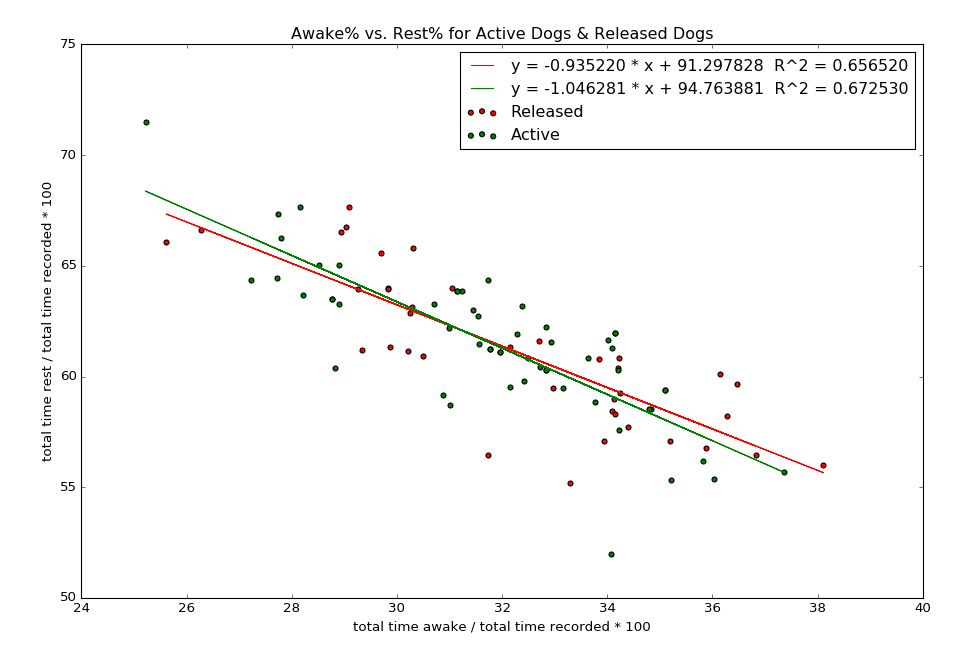

<IPython.core.display.Javascript object>


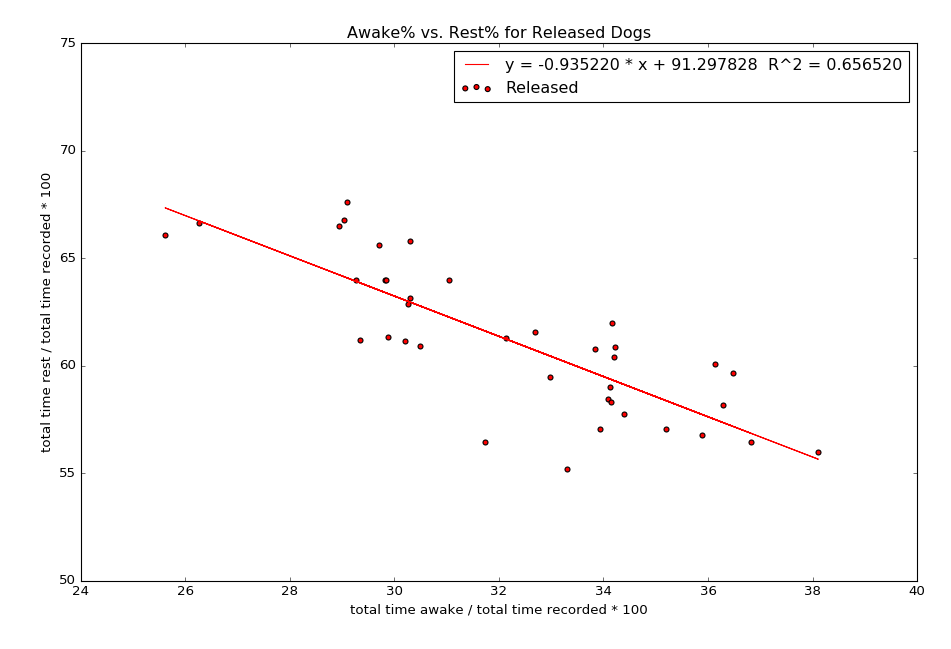

<IPython.core.display.Javascript object>


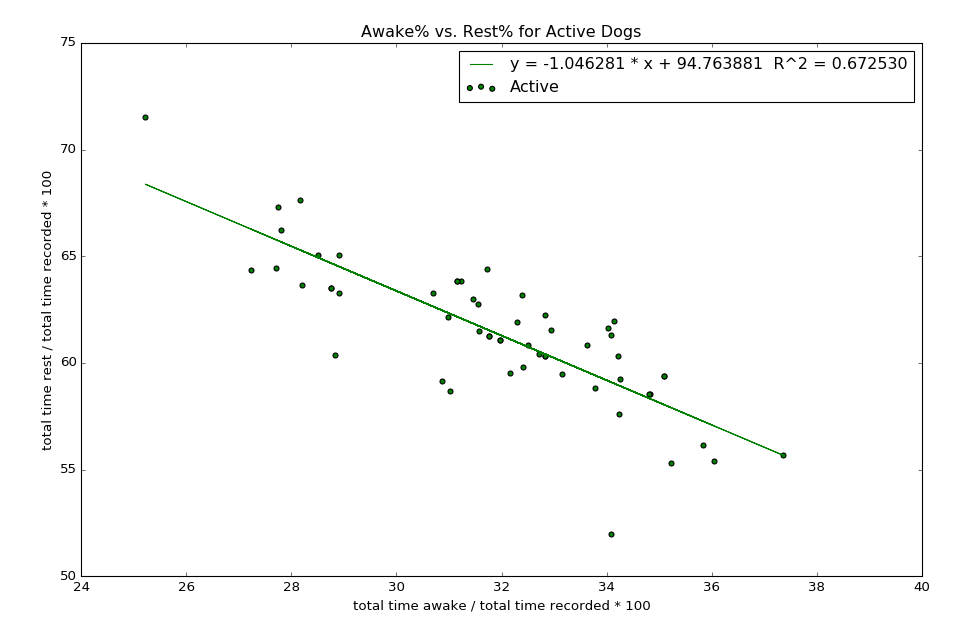

In [28]:
# convert to plottable sets by outcome
ids = []
id_to_outcome = {}
scatter_success = {outcome:[[], []] for outcome in results_by_success.keys()}
for outcome, results in results_by_success.iteritems():
    for dog in results["dogs"]:
        ids.append(dog["id"])
        id_to_outcome[dog["id"]] = outcome
        scatter_success[outcome][0].append(dog["awake%"])
        scatter_success[outcome][1].append(dog["rest%"])

# plot
fig = plt.gcf()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("total time awake / total time recorded * 100")
ax1.set_ylabel("total time rest / total time recorded * 100")
ax1.set_title("Awake% vs. Rest% for Active Dogs & Released Dogs")
colors = {
    "Active":"g",
    "Released":"r"
}
for outcome, xy in scatter_success.items()[::-1]:
    x,y = xy[0], xy[1]
    col = colors[outcome]
    plt.scatter(x, y, c=col, label=outcome)
    # plot regression line
    coeff = np.polyfit(x, y, 1)
    p = np.poly1d(coeff)
    y_fit = p(x)
    y_bar = np.sum(y)/len(y)
    ssreg = np.sum((y_fit-y_bar)**2)
    sstot = np.sum((y - y_bar)**2)
    rs = ssreg / sstot
    label = 'y = %f * x + %f  R^2 = %f' % (coeff[0], coeff[1], rs)
    ax1.plot(x, y_fit, color=col, label=label)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

y_lim, x_lim = ax1.get_ylim(), ax1.get_xlim()

# individual plots
i = 1
for outcome, xy in scatter_success.items()[::-1]:
    i += 1
    ax1 = plt.figure().add_subplot(111)
    ax1.set_xlabel("total time awake / total time recorded * 100")
    ax1.set_ylabel("total time rest / total time recorded * 100")
    ax1.set_title("Awake%% vs. Rest%% for %s Dogs"%outcome)
    x,y = xy[0], xy[1]
    col = colors[outcome]
    plt.scatter(x, y, c=col, label=outcome)
    # plot regression line
    coeff = np.polyfit(x, y, 1)
    p = np.poly1d(coeff)
    y_fit = p(x)
    y_bar = np.sum(y)/len(y)
    ssreg = np.sum((y_fit-y_bar)**2)
    sstot = np.sum((y - y_bar)**2)
    rs = ssreg / sstot
    label = 'y = %f * x + %f  R^2 = %f' % (coeff[0], coeff[1], rs)
    ax1.plot(x, y_fit, color=col, label=label)
    ax1.set_ylim(y_lim)
    ax1.set_xlim(x_lim)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [13]:
"""
ids = []
id_to_outcome = {}
cluster_data = []
scatter_outcome = {outcome:[[], []] for outcome in results_by_outcome.keys()}
for outcome, results in results_by_outcome.iteritems():
    for dog in results["dogs"]:
        ids.append(dog["id"])
        id_to_outcome[dog["id"]] = outcome
        cluster_data.append([dog["rest%"], dog["awake%"]])
        scatter_outcome[outcome][0].append(dog["awake%"])
        scatter_outcome[outcome][1].append(dog["rest%"])

ax1 = plt.figure().add_subplot(111)
ax1.set_xlabel("total time awake / total time recorded * 100")
ax1.set_ylabel("total time rest / total time recorded * 100")
colors = {
    "Active Breeder":"b",
    "Active Grad Dog": "g",
    "Released Dog":"r",
    "Advanced Training": "y",
    "Unknown Status": "k"
}
xs = []
ys = []
for outcome, xy in scatter_outcome.iteritems():
    x,y = xy[0], xy[1]
    xs.append(x)
    ys.append(y)
    plt.scatter(x, y, c=colors[outcome], label=outcome)
plt.legend(loc='upper right');
plt.tight_layout()
plt.show()  
"""
print()

()
